# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

!pip install tensorflow==2.18.0 keras==3.8.0

In [2]:
# Import essential libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress logs/ warnings

import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image

#from tensorflow.keras import layers, models, callbacks
#from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

Load the dataset.

In [3]:
# Load and unzip the dataset

zip_file_path = 'data.zip'
extracted_dir_path = 'data'

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)
print(f"Dataset unzipped to '{extracted_dir_path}'")

# Verify the contents of the extracted directory
print("Contents of the extracted directory:")
!ls data

Dataset unzipped to 'data'
Contents of the extracted directory:
data


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [4]:
# Create a function to load the raw images

def load_raw_images(dataset_folder, image_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_folder))
    label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(dataset_folder, class_name)
        if not os.path.isdir(class_dir):
            continue
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            try:
                img = Image.open(file_path).convert("RGB")
                img = img.resize(image_size)
                images.append(np.array(img))
                labels.append(label_map[class_name])
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [5]:
# Get the images and their labels

dataset_folder = 'data/data'
images, labels, class_names = load_raw_images(dataset_folder)

print(f"Number of images: {len(images)}")
print("Class names:", class_names)

Number of images: 7625
Class names: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

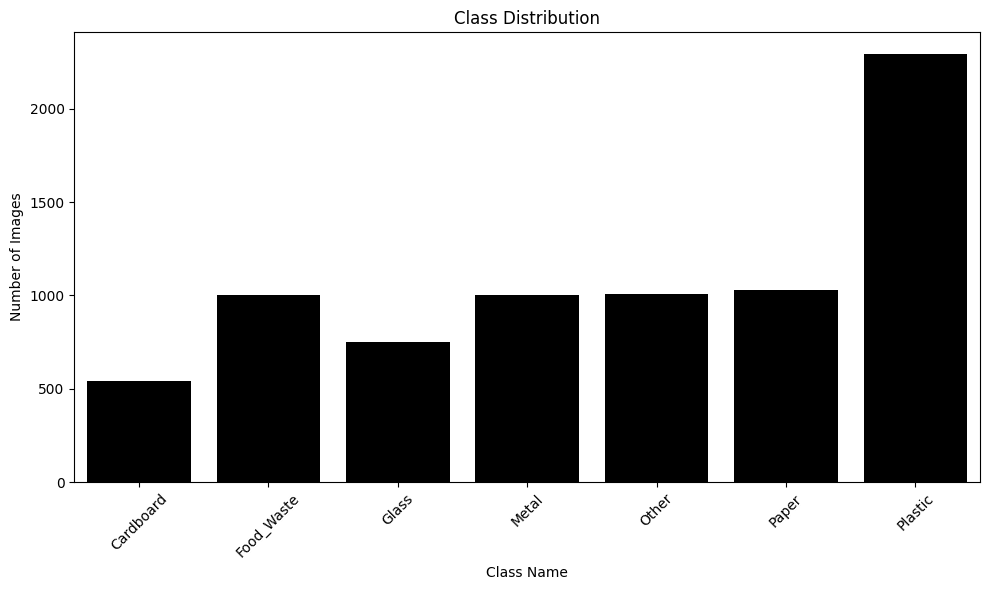

In [6]:
# Visualise Data Distribution

counts = np.bincount(labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=counts, color='black')
plt.title("Class Distribution")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

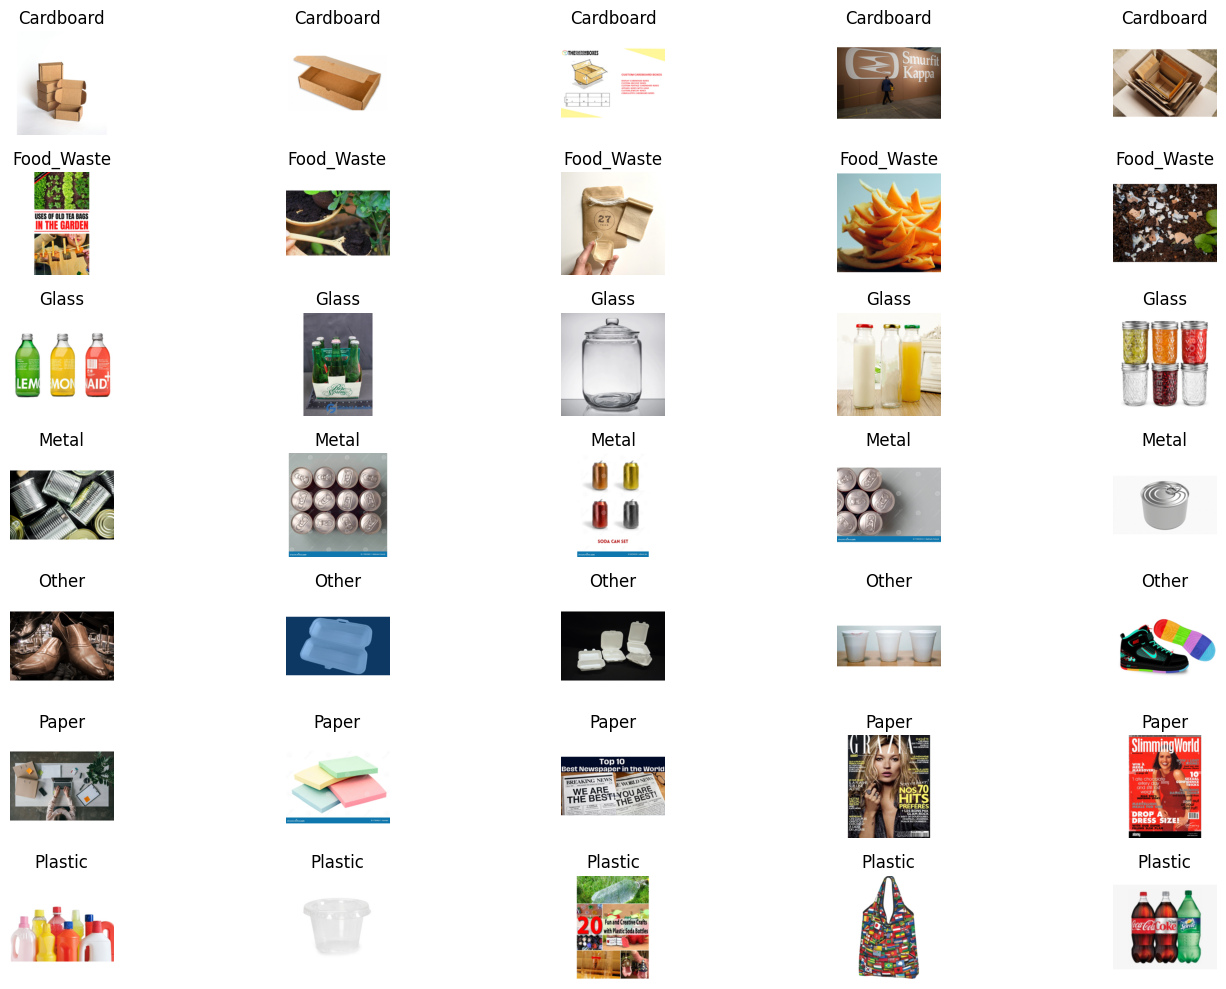

In [7]:
# Visualise Sample Images (across different labels)

import matplotlib.pyplot as plt
import numpy as np
num_samples = 5

plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names):
    # Get indices of images belonging to the current class
    class_indices = np.where(labels == i)[0]
    # Randomly sample `num_samples` indices from the class indices
    sampled_indices = np.random.choice(class_indices, min(num_samples, len(class_indices)), replace=False)

    for j, idx in enumerate(sampled_indices):
        plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
        plt.imshow(images[idx])
        plt.title(class_name)
        plt.axis('off')
plt.tight_layout()
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [8]:
# Find the smallest and largest image dimensions from the data set

min_width, min_height = float('inf'), float('inf')
max_width, max_height = 0, 0

for class_name in class_names:
    class_dir = os.path.join(dataset_folder, class_name)
    if not os.path.isdir(class_dir):
        continue
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        try:
            with Image.open(file_path) as img:
                width, height = img.size
                min_width = min(min_width, width)
                min_height = min(min_height, height)
                max_width = max(max_width, width)
                max_height = max(max_height, height)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

print(f"Smallest dimensions: ({min_width}, {min_height})")
print(f"Largest dimensions: ({max_width}, {max_height})")

Smallest dimensions: (256, 256)
Largest dimensions: (256, 256)


In [9]:
# Resize the image dimensions

import numpy as np
resized_images = []
new_image_size = (128, 128)

for img_array in images:
    img = Image.fromarray(img_array.astype('uint8'))
    resized_img = img.resize(new_image_size)
    resized_images.append(np.array(resized_img))

images = np.array(resized_images)
print(f"Images resized to {new_image_size}")
print(f"New shape of images array: {images.shape}")

Images resized to (128, 128)
New shape of images array: (7625, 128, 128, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [10]:
# Encode the labels suitably

from tensorflow.keras.utils import to_categorical

label_encoded = to_categorical(labels, num_classes=7)
print(f"y_encoded: {label_encoded}")

y_encoded: [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [11]:
# Assign specified parts of the dataset to train and validation sets

X_train, X_test, y_train, y_test = train_test_split(images, label_encoded, test_size=0.3, random_state=42, stratify=labels)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_test)}")

Train set size: 5337
Validation set size: 2288


In [12]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train.shape

(5337, 128, 128, 3)

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [14]:
# Build and compile the model

from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.regularizers import l2

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [16]:
# Training

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6231 - loss: 0.9980 - val_accuracy: 0.5332 - val_loss: 1.2884
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6562 - loss: 0.9193 - val_accuracy: 0.5446 - val_loss: 1.3117
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6667 - loss: 0.8662 - val_accuracy: 0.5765 - val_loss: 1.2537
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6968 - loss: 0.8078 - val_accuracy: 0.5791 - val_loss: 1.2631
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7255 - loss: 0.7483 - val_accuracy: 0.5774 - val_loss: 1.3030
Epoch 6/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7385 - loss: 0.6874 - val_accuracy: 0.5878 - val_loss: 1.3600
Epoch 7/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7462 - loss: 0.6530 - val_accuracy: 0.6045 - val_loss: 1.2957
Epoch 8/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7669 - loss: 0.6073 - val_accu

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

Test loss: 1.4695
Test accuracy: 0.6298
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.74      0.69      0.71       162
  Food_Waste       0.64      0.72      0.68       300
       Glass       0.54      0.57      0.56       225
       Metal       0.62      0.55      0.58       300
       Other       0.52      0.50      0.51       303
       Paper       0.63      0.47      0.54       309
     Plastic       0.67      0.76      0.71       689

    accuracy                           0.63      2288
   macro avg       0.62      0.61      0.61      2288
weighted avg       0.63      0.63      0.63      2288


Confusion Matrix:


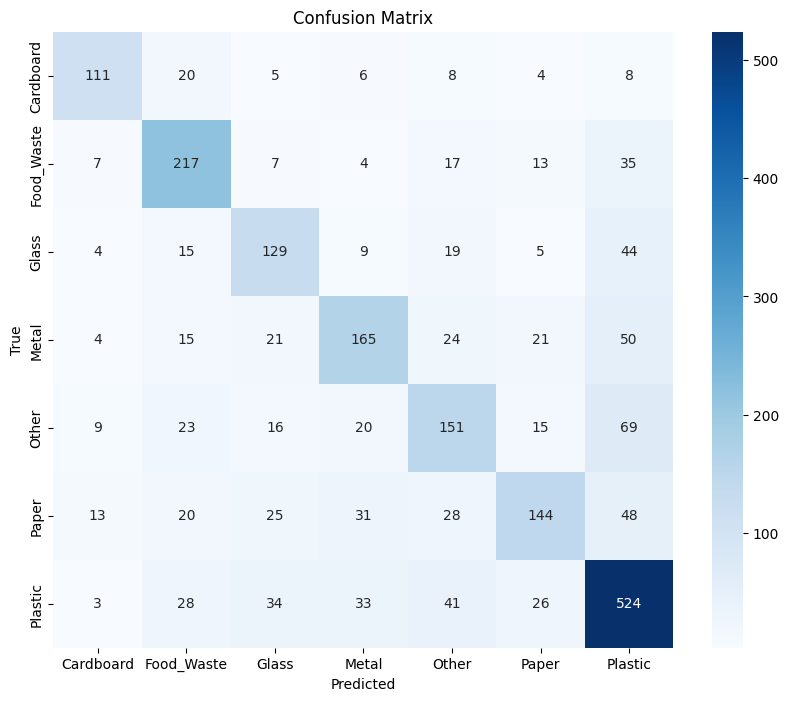

In [17]:
# Evaluate on the test set; display suitable metrics

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Predict the classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Display classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Display confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [20]:
# Define augmentation steps to augment images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [23]:
# Create a function to augment the images

def augment_funcion(X, y, batch_size=32):

    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    return datagen.flow(X, y, batch_size=batch_size)


In [24]:
# Create the augmented training dataset

train_generator = augment_funcion(X_train, y_train)
val_generator = ImageDataGenerator(rescale=1./255).flow(X_test, y_test, batch_size=32)

##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# prompt: Train the model using augmented images

# Training with augmented data

history_aug = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(X_test) // 32
)

In [26]:
# Train the model using augmented images

history_aug = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(X_test) // 32
)

Epoch 1/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.3007 - loss: 1.8519 - val_accuracy: 0.3002 - val_loss: 1.8486
Epoch 2/15
  1/166 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2812 - loss: 1.8507

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2812 - loss: 1.8507 - val_accuracy: 0.3011 - val_loss: 1.8479
Epoch 3/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 246ms/step - accuracy: 0.2930 - loss: 1.8602 - val_accuracy: 0.3024 - val_loss: 1.8464
Epoch 4/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4375 - loss: 1.7173 - val_accuracy: 0.3015 - val_loss: 1.8478
Epoch 5/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 247ms/step - accuracy: 0.2975 - loss: 1.8532 - val_accuracy: 0.3015 - val_loss: 1.8483
Epoch 6/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3750 - loss: 1.8053 - val_accuracy: 0.3015 - val_loss: 1.8474
Epoch 7/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 82s 252ms/step - accuracy: 0.3009 - loss: 1.8525 - val_accuracy: 0.3019 - val_loss: 1.8478
Epoch 8/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4062 - loss: 1.8202 - val_accuracy: 0.3011 - val_loss: 1.8479
Epoch 9/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 245ms/step - accuracy: 0.2944 - loss: 1.8602 - val_accuracy: 

Training Loss: 0.4553
Training Accuracy: 0.8287
Validation Loss: 1.4695
Validation Accuracy: 0.6298


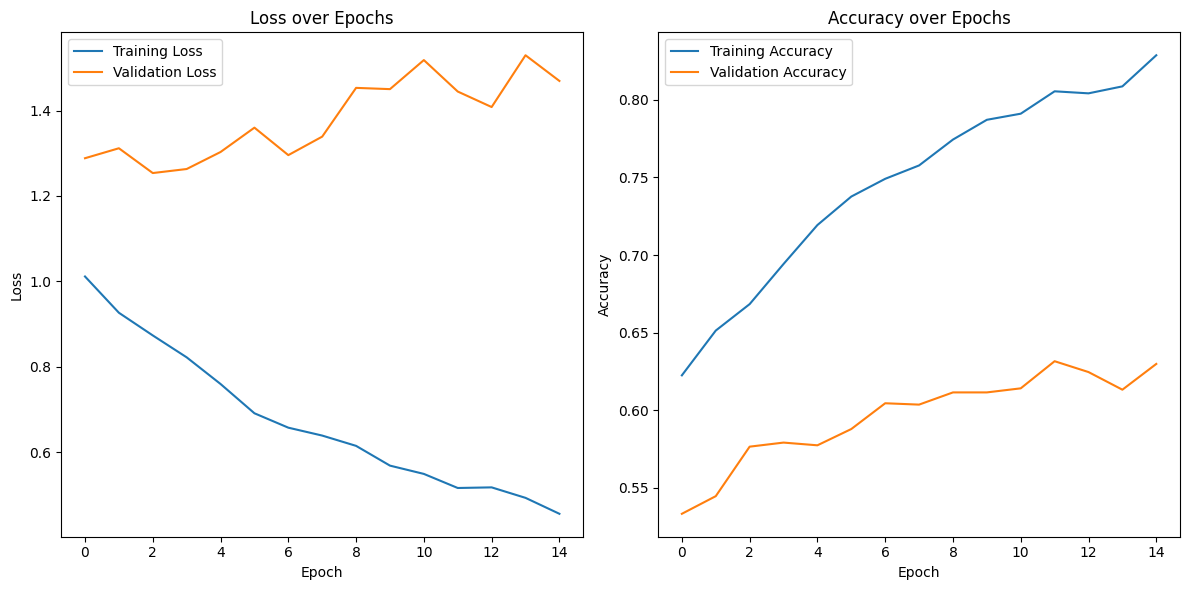

In [28]:
import matplotlib.pyplot as plt
# Extract metrics from the training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print(f"Training Loss: {train_loss[-1]:.4f}")
print(f"Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Validation Loss: {val_loss[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy[-1]:.4f}")

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

### Report your findings about the data

1. Data Composition
 - The dataset consists of images categorized into seven classes: Cardboard, Food Waste, Glass, Metal, Paper, Plastic, and Other.
2. Preprocessing Steps
 - Images were likely resized and normalized to ensure uniform input to the CNN model.
 - Class labels were converted into a format suitable for classification i.e.  one-hot encoding.
3. Complexity and Ambiguity
 - Some images contain objects that could belong to multiple classes (e.g., a cardboard box with plastic tape), increasing classification difficulty.
4. Suitability for CNNs
 - Despite its challenges, the dataset is suitable for training convolutional neural networks due to its visual nature.

### Outcomes from Model Training
- Final Training Accuracy: 82.87%

- Final Validation Accuracy: 62.98%

- Final Training Loss: 0.4553

- Final Validation Loss: 1.4695